<a href="https://colab.research.google.com/github/yuribp0107/Curso-CNN-RX/blob/main/Taller_Redes_Neuronales_Convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Instalacion de librerias**

In [ ]:
from google.colab import drive  # Módulo de Colab que facilita el acceso a Google Drive
drive.mount('/content/drive')   # Monta tu Google Drive en /content/drive para leer y escribir archivos


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import random
import numpy as np
import matplotlib

# Para manejo de datos y visualización
import os
import numpy as np
import random
import matplotlib.pyplot as plt


# TensorFlow y Keras para la red neuronal
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras import layers, models


# Mostrar versión (útil para reproducibilidad)
print("TensorFlow versión:", tf.__version__)

print("🧪 Versiones del entorno:")
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print("os: (librería estándar, sin versión independiente)")
print("random: (librería estándar, sin versión independiente)")


TensorFlow versión: 2.18.0
🧪 Versiones del entorno:
Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
numpy: 2.0.2
matplotlib: 3.10.0
os: (librería estándar, sin versión independiente)
random: (librería estándar, sin versión independiente)


##**Imagenes**

In [ ]:
# Carpeta raíz donde descomprimiste el ZIP
base_dir = '/content/drive/MyDrive/chest_xray_pneumonia/chest_xray'

# Subdirectorios para entrenamiento, validación y prueba
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

print("Entrenamiento:", os.listdir(train_dir))
print("Validación:",   os.listdir(val_dir))
print("Prueba:",       os.listdir(test_dir))


Entrenamiento: ['NORMAL', 'PNEUMONIA']
Validación: ['NORMAL', 'PNEUMONIA']
Prueba: ['NORMAL', 'PNEUMONIA']


Resumen de imágenes:
 - Train: 5216 (NORMAL: 1341, PNEUMONIA: 3875)
 - Val:   16   (NORMAL: 8, PNEUMONIA: 8)
 - Test:  624  (NORMAL: 234, PNEUMONIA: 390)



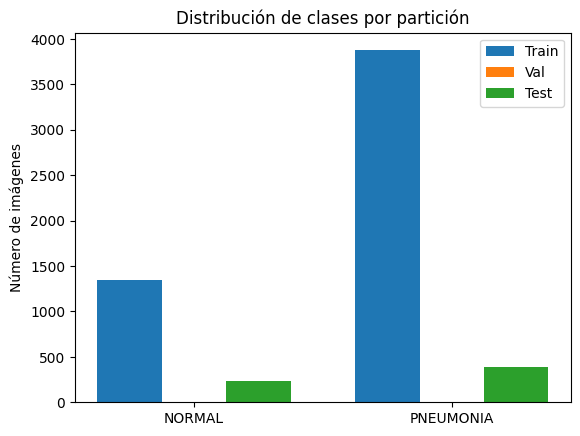

In [ ]:
# Función para contar imágenes por clase en un directorio dado
def count_images(directory):
    counts = {}
    for clase in os.listdir(directory):
        clase_dir = os.path.join(directory, clase)
        if os.path.isdir(clase_dir):
            counts[clase] = len([f for f in os.listdir(clase_dir)
                                 if os.path.isfile(os.path.join(clase_dir, f))])
    return counts

# Contamos imágenes en cada partición
train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)
test_counts  = count_images(test_dir)

# Preparamos datos para el gráfico
particiones = ['Train', 'Val', 'Test']
clases      = list(train_counts.keys())  # NORMAL, PNEUMONIA
datos = {
    'Train': [train_counts[c] for c in clases],
    'Val':   [val_counts[c]   for c in clases],
    'Test':  [test_counts[c]  for c in clases]
}

# Imprimimos un resumen
total_train = sum(train_counts.values())
total_val   = sum(val_counts.values())
total_test  = sum(test_counts.values())

print(f"Resumen de imágenes:")
print(f" - Train: {total_train} ({', '.join([f'{c}: {train_counts[c]}' for c in clases])})")
print(f" - Val:   {total_val}   ({', '.join([f'{c}: {val_counts[c]}'   for c in clases])})")
print(f" - Test:  {total_test}  ({', '.join([f'{c}: {test_counts[c]}'  for c in clases])})\n")

# Graficamos la distribución
x = np.arange(len(clases))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, datos['Train'], width, label='Train')
ax.bar(x,         datos['Val'],   width, label='Val')
ax.bar(x + width, datos['Test'],  width, label='Test')

ax.set_ylabel('Número de imágenes')
ax.set_title('Distribución de clases por partición')
ax.set_xticks(x)
ax.set_xticklabels(clases)
ax.legend()
plt.show()


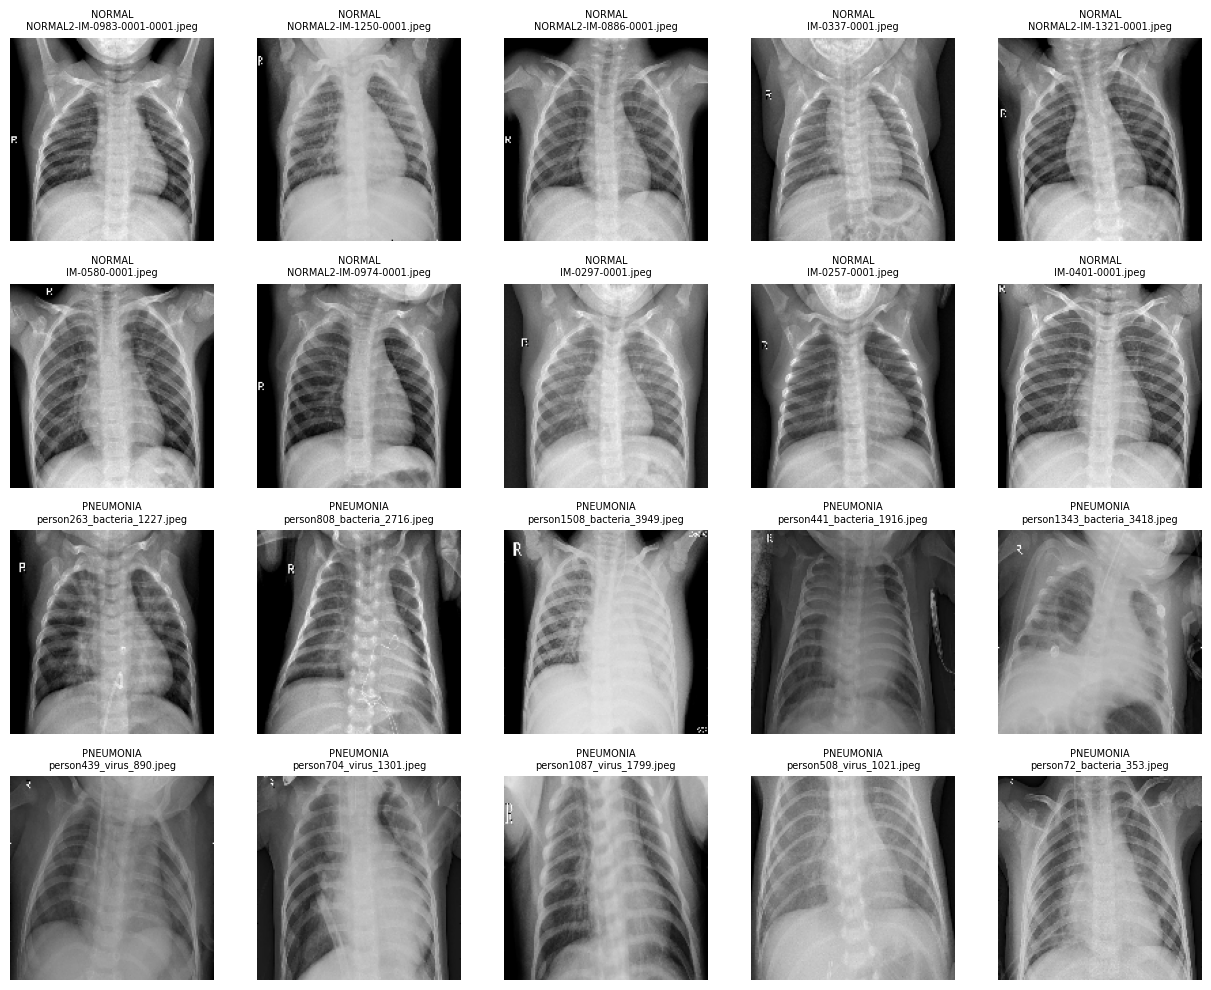

In [ ]:
def mostrar_dos_filas_por_clase(dir_base, clases, filas_por_clase=2, cols=5, target_size=(150,150)):
    """
    Muestra filas_por_clase filas de cada clase, con cols imágenes por fila.
    """
    total_filas = filas_por_clase * len(clases)
    fig, axes = plt.subplots(
        nrows=total_filas,
        ncols=cols,
        figsize=(cols * 2.5, total_filas * 2.5)
    )

    for ci, clase in enumerate(clases):
        carpeta = os.path.join(dir_base, clase)
        archivos = [
            f for f in os.listdir(carpeta)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        # Elegimos filas_por_clase * cols imágenes sin repetir
        seleccion = random.sample(archivos, min(len(archivos), filas_por_clase * cols))

        for fila in range(filas_por_clase):
            imgs_fila = seleccion[fila * cols : (fila + 1) * cols]
            for col, fname in enumerate(imgs_fila):
                ax = axes[ci * filas_por_clase + fila, col]
                img = load_img(os.path.join(carpeta, fname), target_size=target_size)
                ax.imshow(img, cmap='gray')
                ax.axis('off')
                ax.set_title(f"{clase}\n{fname}", fontsize=7)

    plt.tight_layout()
    plt.show()

# Uso:
clases = ['NORMAL', 'PNEUMONIA']
mostrar_dos_filas_por_clase(train_dir, clases, filas_por_clase=2, cols=5)


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display, clear_output

# Directorio base (ajusta si quieres ver 'val' o 'test')
image_dir = train_dir

# Obtener clases (NORMAL, PNEUMONIA)
classes = sorted(os.listdir(image_dir))

# Dropdown para elegir clase
class_selector = widgets.Dropdown(
    options=classes,
    value=classes[0],
    description='Clase:',
)

# Slider para seleccionar índice de imagen
slider = widgets.IntSlider(value=0, min=0, max=1, step=1, description='Índice')

# Contenedor de visualización
output = widgets.Output()

# Actualiza las imágenes del slider y muestra la imagen actual
def update_class(change):
    selected_class = class_selector.value
    image_list = sorted(os.listdir(os.path.join(image_dir, selected_class)))
    slider.max = len(image_list) - 1
    slider.value = 0
    show_image(0)

# Mostrar imagen actual
def show_image(index):
    selected_class = class_selector.value
    image_list = sorted(os.listdir(os.path.join(image_dir, selected_class)))
    image_path = os.path.join(image_dir, selected_class, image_list[index])

    img = mpimg.imread(image_path)
    with output:
        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray')
        plt.title(f"{selected_class} - {image_list[index]}")
        plt.axis('off')
        plt.show()

# Enlazar eventos
class_selector.observe(update_class, names='value')
slider.observe(lambda change: show_image(change['new']), names='value')

# Mostrar widgets y visualización
display(widgets.VBox([class_selector, slider, output]))

# Inicializar con valores por defecto
update_class(None)


##**Preprocesamiento**

In [ ]:
# Normalizamos píxeles a [0,1] y aplicamos augmentations solo en el set de entrenamiento
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Para validación y test, solo rescale
val_test_gen = ImageDataGenerator(rescale=1./255)

# Generadores que leen imágenes desde disco
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)
val_data = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)
test_data = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


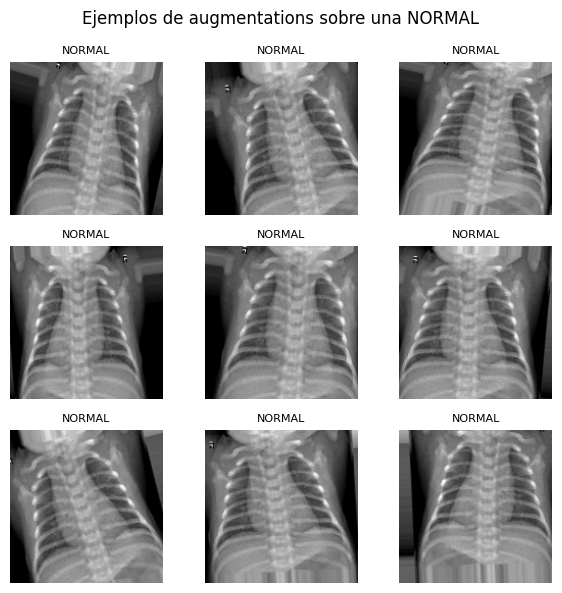

In [ ]:

# 1. Elegimos al azar una imagen de entrenamiento de la clase NORMAL (puedes cambiar a PNEUMONIA)
clase_ejemplo = 'NORMAL'
ruta_clase = os.path.join(train_dir, clase_ejemplo)
archivo = random.choice([
    f for f in os.listdir(ruta_clase)
    if f.lower().endswith(('.png','.jpg','.jpeg'))
])
ruta_img = os.path.join(ruta_clase, archivo)

# 2. Cargamos y preparamos la imagen
img = load_img(ruta_img, target_size=(150,150))
x = img_to_array(img)            # convierte a array (150,150,3)
x = x.reshape((1,) + x.shape)    # añade dimensión de batch, queda (1,150,150,3)

# 3. Creamos un iterador de augmentations
aug_iter = train_gen.flow(x, batch_size=1)

# 4. Mostramos 9 variaciones
plt.figure(figsize=(6,6))
for i in range(9):
    batch = next(aug_iter)       # un batch de tamaño 1
    img_aug = batch[0]           # extraemos la imagen
    plt.subplot(3,3,i+1)
    plt.imshow(img_aug)
    plt.axis('off')
    plt.title(f"{clase_ejemplo}", fontsize=8)

plt.suptitle('Ejemplos de augmentations sobre una NORMAL', fontsize=12)
plt.tight_layout()
plt.show()


##**Entrenamiento**

In [ ]:
model = models.Sequential([
    # Capa convolucional + pooling
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Aplanar y conectar densamente
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Salida binaria: normal vs neumonía
    layers.Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_data,
    epochs=2,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7501 - loss: 0.6251 - val_accuracy: 0.6875 - val_loss: 1.3360
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8837 - loss: 0.2849 - val_accuracy: 0.8125 - val_loss: 0.5352


##**Evaluacion del modelo**

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"\nPrecisión en test: {test_acc*100:.2f}%")


In [ ]:
# Precisión
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()
